In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import datetime as dt

from statsmodels.tsa.arima_model import ARIMA

from twitterscraper import query_tweets
from wordcloud import WordCloud, STOPWORDS

INFO: {'User-Agent': 'Opera/9.80 (X11; Linux i686; Ubuntu/14.10) Presto/2.12.388 Version/12.16'}


In [2]:
def prepare_data():
    
    df = pd.read_csv(r'C:\Users\Valentin\Documents\Python Scripts\data\stock-lvmh.csv')
    
    df['var'] = df['Close'] - df['Open']
    df['bin_var'] = df['var'].map(lambda x: 1 if x>0 else 0)
    df['Date'] = pd.to_datetime(df['Date'])
    df['var_pc'] = df['var'] / df['Open']*100
    
    df['var_buy'] = df['var_pc'].map(lambda x: 1 if x>0.5 else 0)
    
    
    df = df[df.var_pc < 200] #we saw problems during EDA
    
    display(df.head())
    display(df.info())
    
    return df

In [3]:
data = prepare_data()

,Date,Open,High,Low,Close,Adj Close,Volume,var,bin_var,var_pc,var_buy
0,2000-01-03,91.779999,93.180000,88.199997,88.800003,58.075012,615855.0,-2.979996,0,-3.246890,0
1,2000-01-04,90.800003,90.800003,80.400002,80.400002,52.581455,1691700.0,-10.400001,0,-11.453745,0
2,2000-01-05,79.000000,79.800003,76.000000,77.680000,50.802563,1563735.0,-1.320000,0,-1.670886,0
3,2000-01-06,77.599998,77.599998,74.459999,76.800003,50.227066,1641215.0,-0.799995,0,-1.030921,0
4,2000-01-07,76.400002,76.800003,74.019997,76.800003,50.227066,1360530.0,0.400001,1,0.523562,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5254 entries, 0 to 5273
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5254 non-null   datetime64[ns]
 1   Open       5254 non-null   float64       
 2   High       5254 non-null   float64       
 3   Low        5254 non-null   float64       
 4   Close      5254 non-null   float64       
 5   Adj Close  5254 non-null   float64       
 6   Volume     5254 non-null   float64       
 7   var        5254 non-null   float64       
 8   bin_var    5254 non-null   int64         
 9   var_pc     5254 non-null   float64       
 10  var_buy    5254 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 492.6 KB


None

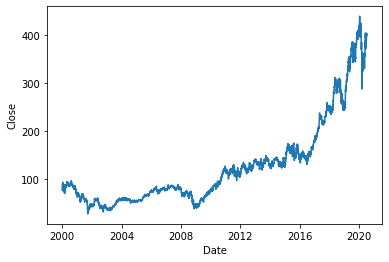

In [4]:
sb.lineplot(data.Date, data.Close)

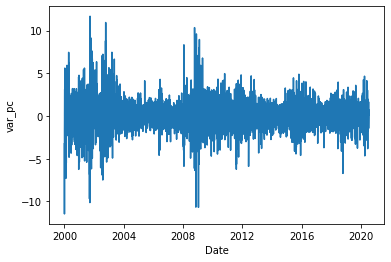

In [5]:
sb.lineplot(data.Date, data.var_pc)

In [6]:
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [7]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [8]:
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

<class 'list'>


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 25.229
Symmetric mean absolute percentage error: 33.795


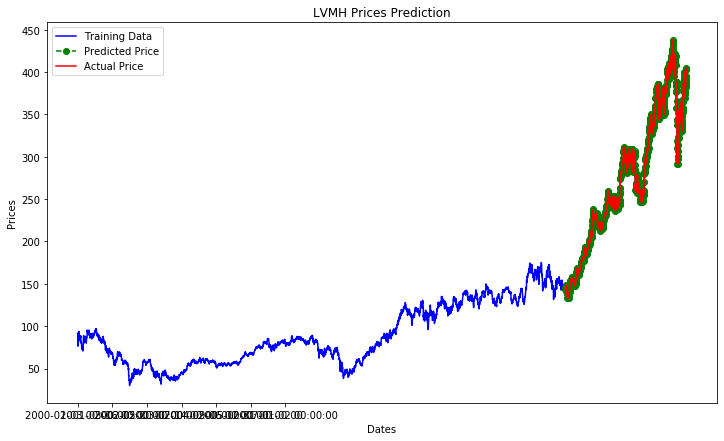

In [10]:
plt.figure(figsize=(12,7))
plt.plot(data['Open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('LVMH Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,1857, 300), data['Date'][0:1857:300])
plt.legend()

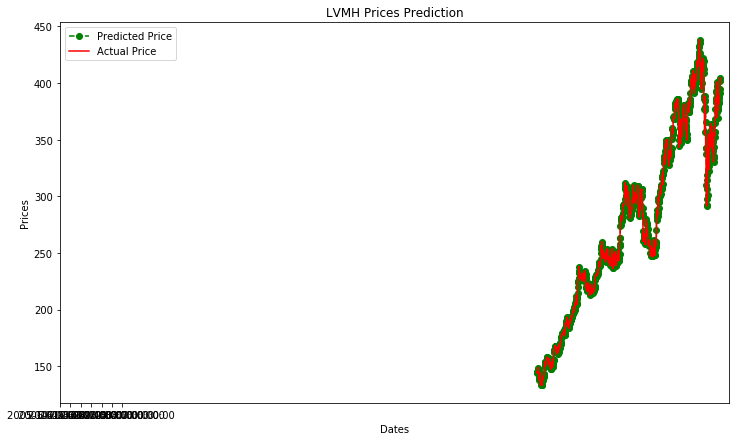

In [11]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.xticks(np.arange(1486,1856, 60), data['Date'][1486:1856:60])
plt.title('LVMH Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()